# Decompose the SSH into manometric and steric components
## $\eta = \eta_m + \eta_s = \frac{p_b}{\rho_0 g} - \frac{1}{\rho_0}\int_{-H}^0{\rho'}dz $
# , and decompose steric SSH into thermosteric and halosteric parts

In [1]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:45157")
client

<Client: 'tcp://127.0.0.1:45157' processes=8 threads=32, memory=246.60 GiB>

In [2]:
# tell Python to use the ecco_v4_py in the 'ECCOv4-py' repository
from os.path import join,expanduser
import sys

# identify user's home directory
user_home_dir = expanduser('~')

# import the ECCOv4 py library 
sys.path.insert(0,join(user_home_dir,'ECCOv4-py'))
import ecco_v4_py as ecco
import ecco_v4_py.ecco_access as ea

from scipy.stats import linregress
import fsspec
import zarr

import botocore  
import boto3
from boto3.session import Session
import cmocean
from collections import Counter
from dask.distributed import Client
import datetime
import fsspec
from gc import get_referents
import json
import numpy as np
from pathlib import Path
from pprint import pprint
import requests
import s3fs
import sys
from sys import getsizeof
import time as time
from types import ModuleType, FunctionType
import xarray as xr
import matplotlib.pyplot as plt
import zarr
import gsw

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

#-------------------------------------------------------------------------|
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Use this for the netcdf files stored on an s3 bucket
def get_credentials(use_earthdata=False):
    """
    This routine automatically pulls your EDL crediential from .netrc file and use it to obtain an AWS S3 credential 
    through a PO.DAAC service accessible at https://archive.podaac.earthdata.nasa.gov/s3credentials.
    From the PO.DAAC Github (https://podaac.github.io/tutorials/external/July_2022_Earthdata_Webinar.html).
    
    Returns:
    =======
    
    credentials: a dictionary with AWS secret_key, access_key, and token
    """
    # NASA EarthData hosts ECCO V4r4 fileds
    if use_earthdata == False:
        session = boto3.Session()
        credentials_b3 = session.get_credentials()
        creds_b3 = credentials_b3.get_frozen_credentials()
        
        credentials = dict()
        credentials['secretAccessKey'] = credentials_b3.secret_key
        credentials['accessKeyId'] = credentials_b3.access_key
        credentials['sessionToken'] = credentials_b3.token

    # A 'public' AWS s3 bucket hosts V4r5 fields (they will eventually move to PO.DAAC)
    else:
        credentials = requests.get('https://archive.podaac.earthdata.nasa.gov/s3credentials').json()
    
    return credentials
    

In [4]:
def init_S3FileSystem(use_earthdata=False, requester_pays=True):
    """
    This routine automatically creates an 's3 file system' object and credentials dictionary.
    The s3 file system needs to be initialized with the special aws credentials.
    
    Returns:
    =======
    
    s3: an AWS S3 filesystem, 
    credentials: a dictionary with AWS secret_key, access_key, and token

    """
    credentials = get_credentials(use_earthdata=use_earthdata)

    if use_earthdata:
        requester_pays = False
        
    s3 = s3fs.S3FileSystem(requester_pays=requester_pays,
                           anon=False,
                           key=credentials['accessKeyId'],
                           secret=credentials['secretAccessKey'], 
                           token=credentials['sessionToken'])
    
    return s3, credentials

In [5]:
s3, credentials = init_S3FileSystem(use_earthdata=False, requester_pays=True);
mzz_local_directory = Path('/efs_ecco/mzz-jsons-V4r5/MZZ_mon_mean_native')
# mzz_local_directory = Path('/efs_ecco/mzz-jsons-V4r5/MZZ_snap_native')
# different prefixes on s3
# MZZ_day_mean_latlon
# MZZ_day_mean_native
# MZZ_mon_mean_latlon
# MZZ_mon_mean_native
# MZZ_snap_native

# load mon means: SSH, pressure, T,S

In [6]:
# MZZ files have been downloaded. 
# select the SSH dataset
TS_file = mzz_local_directory / 'OCEAN_TEMPERATURE_SALINITY_mon_mean_native_llc090_ECCOV4r5.json'
DEN_file = mzz_local_directory / 'OCEAN_DENS_STRAT_PRESS_mon_mean_native_llc090_ECCOV4r5.json'
PRE_file = mzz_local_directory / 'OCEAN_BOTTOM_PRESSURE_mon_mean_native_llc090_ECCOV4r5.json'
SSH_file = mzz_local_directory / 'SEA_SURFACE_HEIGHT_mon_mean_native_llc090_ECCOV4r5.json'

print(TS_file)
print(DEN_file)
print(PRE_file)
print(SSH_file)

/efs_ecco/mzz-jsons-V4r5/MZZ_mon_mean_native/OCEAN_TEMPERATURE_SALINITY_mon_mean_native_llc090_ECCOV4r5.json
/efs_ecco/mzz-jsons-V4r5/MZZ_mon_mean_native/OCEAN_DENS_STRAT_PRESS_mon_mean_native_llc090_ECCOV4r5.json
/efs_ecco/mzz-jsons-V4r5/MZZ_mon_mean_native/OCEAN_BOTTOM_PRESSURE_mon_mean_native_llc090_ECCOV4r5.json
/efs_ecco/mzz-jsons-V4r5/MZZ_mon_mean_native/SEA_SURFACE_HEIGHT_mon_mean_native_llc090_ECCOV4r5.json


## load grid

In [7]:
grid_params_shortname = "ECCO_L4_GEOMETRY_LLC0090GRID_V4R4"
access_mode = 'download'

# download root (parent) directory
grid_fnm = '/efs_ecco/ECCO/V4/r5/netcdf/native/geometry/GRID_GEOMETRY_ECCO_V4r5_native_llc0090.nc'
ds_grid = xr.open_dataset(grid_fnm)
ds_grid

<xarray.Dataset> Size: 92MB
Dimensions:                 (i: 90, i_g: 90, j: 90, j_g: 90, k: 50, k_u: 50,
                             k_l: 50, k_p1: 51, tile: 13, nbh: 4, nv: 2)
Coordinates: (12/20)
  * i                       (i) int32 360B 0 1 2 3 4 5 6 ... 84 85 86 87 88 89
  * i_g                     (i_g) int32 360B 0 1 2 3 4 5 6 ... 84 85 86 87 88 89
  * j                       (j) int32 360B 0 1 2 3 4 5 6 ... 84 85 86 87 88 89
  * j_g                     (j_g) int32 360B 0 1 2 3 4 5 6 ... 84 85 86 87 88 89
  * k                       (k) int32 200B 0 1 2 3 4 5 6 ... 44 45 46 47 48 49
  * k_u                     (k_u) int32 200B 0 1 2 3 4 5 6 ... 44 45 46 47 48 49
    ...                      ...
    Zp1                     (k_p1) float32 204B ...
    Zu                      (k_u) float32 200B ...
    Zl                      (k_l) float32 200B ...
    XC_bnds                 (tile, j, i, nbh) float32 2MB ...
    YC_bnds                 (tile, j, i, nbh) float32 2MB ...
    Z_bnds                  (k, nv) float32 400B ...
Dimensions without coordinates: nbh, nv
Data variables: (12/29)
    CS                      (tile, j, i) float32 421kB ...
    SN                      (tile, j, i) float32 421kB ...
    rA                      (tile, j, i) float32 421kB ...
    dxG                     (tile, j_g, i) float32 421kB ...
    dyG                     (tile, j, i_g) float32 421kB ...
    Depth                   (tile, j, i) float32 421kB ...
    ...                      ...
    dyF                     (tile, j, i) float32 421kB ...
    dyU                     (tile, j_g, i_g) float32 421kB ...
    rLowC                   (tile, j, i) float32 421kB ...
    rSurfC                  (tile, j, i) float32 421kB ...
    ocean_column_thickness  (tile, j, i) float32 421kB ...
    ice_shelf_draft         (tile, j, i) float32 421kB ...
Attributes: (12/61)
    acknowledgement:                 This research was carried out by the Jet...
    author:                          Ian Fenty, Ou Wang, Ichiro Fukumori
    cdm_data_type:                   Grid
    comment:                         Fields provided on the curvilinear lat-l...
    Conventions:                     CF-1.8, ACDD-1.3
    creator_email:                   ecco-group@mit.edu
    ...                              ...
    source:                          The ECCO state estimate was produced by ...
    standard_name_vocabulary:        NetCDF Climate and Forecast (CF) Metadat...
    summary:                         This dataset provides geometric paramete...
    title:                           ECCO Geometry Parameters - llc90 Grid (V...
    uuid:                            ef749a0c-e985-11ed-a16e-0242ac110002
    coordinates_comment:             Note: the global 'coordinates' attribute...

# 1. read data (all times), SSH, pressure, density, T/S

In [8]:
fs_TS = fsspec.filesystem("reference",     
                       fo=str(TS_file),
                       remote_protocol="s3",
                       remote_options={"anon":False, "requester_pays":True},
                       skip_instance_cache=True)
fs_TS.asynchronous = True
store = zarr.storage.FsspecStore(fs_TS)
ds_TS = xr.open_dataset(store, engine='zarr',
                     consolidated=False, chunks={'time':2, 'Z':50}) # 

# 
fs_DEN = fsspec.filesystem("reference",     
                       fo=str(DEN_file),
                       remote_protocol="s3",
                       remote_options={"anon":False, "requester_pays":True},
                       skip_instance_cache=True)
fs_DEN.asynchronous = True
store = zarr.storage.FsspecStore(fs_DEN)
ds_DEN = xr.open_dataset(store, engine='zarr',
                     consolidated=False, chunks={'time':2, 'Z':50}) # 


fs_PRE = fsspec.filesystem("reference",     
                       fo=str(PRE_file),
                       remote_protocol="s3",
                       remote_options={"anon":False, "requester_pays":True},
                       skip_instance_cache=True)
fs_PRE.asynchronous = True
store = zarr.storage.FsspecStore(fs_PRE)
ds_PRE = xr.open_dataset(store, engine='zarr',
                     consolidated=False, chunks={'time':2, 'Z':50}) # 


fs_SSH = fsspec.filesystem("reference",     
                       fo=str(SSH_file),
                       remote_protocol="s3",
                       remote_options={"anon":False, "requester_pays":True},
                       skip_instance_cache=True)
fs_SSH.asynchronous = True
store = zarr.storage.FsspecStore(fs_SSH)
ds_SSH = xr.open_dataset(store, engine='zarr',
                     consolidated=False, chunks={'time':2, 'Z':50}) # 


In [9]:
itime = ((ds_PRE.time >= np.array(datetime.datetime(1993,1,1)).astype('datetime64[ns]')) & 
         (ds_PRE.time <= np.array(datetime.datetime(2019,12,31)).astype('datetime64[ns]')))

eta = ds_SSH.SSH[itime,:,:,:].compute()
rhoanom = ds_DEN.RHOAnoma[itime,:,:,:].compute()
phihy = ds_DEN.PHIHYDcR[itime,:,:,:,:].compute()
temp_pot = ds_TS.THETA[itime,:,:,:].compute()
sal_abs = ds_TS.SALT[itime,:,:,:].compute()

# some parameters

In [10]:
g = 9.81
rhoConst = 1029.
p_atm = 101325.   # atmospheric pressure at sea surface, in Pa
S_Ar = 35.16504    # absolute salinity standard for spec. vol., notated as SSO in GSW documentation
T_Cr = 0.    # conservative temperature standard
temp_cons = gsw.conversions.CT_from_pt(sal_abs,temp_pot)
press = (phihy + (g*(-ds_grid.Z)))*rhoConst   # pressure
press_sea = press - p_atm    # pressure minus mean atmospheric pressure

# 2. manometric component $\eta_m = \frac{p_b}{\rho_0 g}$

In [11]:
eta_m = ds_PRE.OBP[itime,:,:,:].compute()

# 3. steric component $- \frac{1}{\rho_0}\frac{H+\eta}{H}\int_{-H}^0{\rho'}dz* $

In [12]:
sstar = (ds_grid.Depth + eta) / ds_grid.Depth
rho_zsum = (rhoanom * ds_grid.drF * ds_grid.hFacC).sum(dim='k')
eta_s = - 1/rhoConst * sstar * rho_zsum # use eta_N
eta_s = eta_s.transpose('time', 'tile', 'j', 'i')

# 4. decompose $\eta_s$ into thermosteric and halosteric parts:
## $\eta_{s-T} = - \frac{1}{\rho_0}\frac{H+\eta}{H}\int_{-H}^0{ [\rho(S_r,T,p) - \rho(S_r,T_r,p)] }dz^* $
## $\eta_{s-S} = - \frac{1}{\rho_0}\frac{H+\eta}{H}\int_{-H}^0{ [\rho(S,T_r,p) - \rho(S_r,T_r,p)] }dz^* $

In [13]:
den_thermo_anom = gsw.density.rho(S_Ar,temp_cons,(1.e-4)*press_sea.values) - rhoConst
den_halo_anom = gsw.density.rho(sal_abs,T_Cr,(1.e-4)*press_sea.values) - rhoConst

# integrate vertically to obtain height anomalies
eta_s_T = -(den_thermo_anom * ds_grid.drF * ds_grid.hFacC).sum("k") * sstar / rhoConst
eta_s_S = -(den_halo_anom * ds_grid.drF * ds_grid.hFacC).sum("k") * sstar / rhoConst

# 5. plot

## calc global mean and local linear trends

In [14]:
eta_anom = eta - eta[0,:,:,:]
etam_anom = eta_m - eta_m[0,:,:,:]
etas_anom = eta_s - eta_s[0,:,:,:]
etas_T_anom = eta_s_T - eta_s_T[0,:,:,:]
etas_S_anom = eta_s_S - eta_s_S[0,:,:,:]

# ---- global mean
eta_area = eta_anom.weighted(ds_grid.rA).mean(dim=('tile', "j", "i")) 
etam_area = etam_anom.weighted(ds_grid.rA).mean(dim=('tile', "j", "i"))
etas_area = etas_anom.weighted(ds_grid.rA).mean(dim=('tile', "j", "i"))
etas_T_area = etas_T_anom.weighted(ds_grid.rA).mean(dim=('tile', "j", "i"))
etas_S_area = etas_S_anom.weighted(ds_grid.rA).mean(dim=('tile', "j", "i"))

# ---- trend at each point
poly = eta_anom.polyfit(dim='time',deg=1)
trend_eta = poly.polyfit_coefficients.sel(degree=1)
trend_eta = trend_eta*12*1e3*2548800000000000 # mm/yr
# mano
poly = etam_anom.polyfit(dim='time',deg=1)
trend_etam = poly.polyfit_coefficients.sel(degree=1)
trend_etam = trend_etam*12*1e3*2548800000000000 # mm/yr
# steric
poly = etas_anom.polyfit(dim='time',deg=1)
trend_etas = poly.polyfit_coefficients.sel(degree=1)
trend_etas = trend_etas*12*1e3*2548800000000000 # mm/yr
# thermo
poly = etas_T_anom.polyfit(dim='time',deg=1)
trend_etas_T = poly.polyfit_coefficients.sel(degree=1)
trend_etas_T = trend_etas_T*12*1e3*2548800000000000 # mm/yr
# halo
poly = etas_S_anom.polyfit(dim='time',deg=1)
trend_etas_S = poly.polyfit_coefficients.sel(degree=1)
trend_etas_S = trend_etas_S*12*1e3*2548800000000000 # mm/yr

## remove seasonal cycles

In [15]:
# eta_anom = eta - eta[0,:,:,:]
# etam_anom = eta_m - eta_m[0,:,:,:]
# etas_anom = eta_s - eta_s[0,:,:,:]
# etas_T_anom = eta_s_T - eta_s_T[0,:,:,:]
# etas_S_anom = eta_s_S - eta_s_S[0,:,:,:]

eta_clim = eta_anom.groupby("time.month").mean()
eta_dess = eta_anom.groupby('time.month') - eta_clim

etam_clim = etam_anom.groupby("time.month").mean()
etam_dess = etam_anom.groupby('time.month') - etam_clim

etas_clim = etas_anom.groupby("time.month").mean()
etas_dess = etas_anom.groupby('time.month') - etas_clim

etasT_clim = etas_T_anom.groupby("time.month").mean()
etasT_dess = etas_T_anom.groupby('time.month') - etasT_clim

etasS_clim = etas_S_anom.groupby("time.month").mean()
etasS_dess = etas_S_anom.groupby('time.month') - etasS_clim


# ---- global mean
eta_dess_area = eta_dess.weighted(ds_grid.rA).mean(dim=('tile', "j", "i")) 
etam_dess_area = etam_dess.weighted(ds_grid.rA).mean(dim=('tile', "j", "i"))
etas_dess_area = etas_dess.weighted(ds_grid.rA).mean(dim=('tile', "j", "i"))
etas_T_dess_area = etasT_dess.weighted(ds_grid.rA).mean(dim=('tile', "j", "i"))
etas_S_dess_area = etasS_dess.weighted(ds_grid.rA).mean(dim=('tile', "j", "i"))

## plot global mean SL

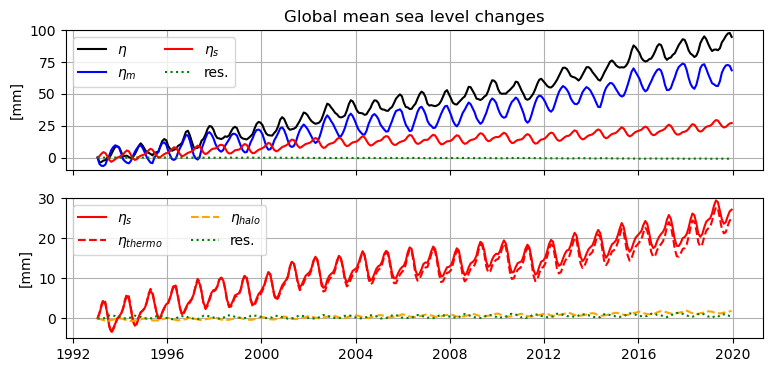

In [16]:
res_area = eta_area - etam_area - etas_area 
res_areaSteric = etas_area - etas_T_area - etas_S_area 
fac = 1e3

plt.figure(figsize=(9,4))
plt.subplot(2,1,1)
# ax = fig.add_subplot(2, 2, 1)
plt.plot(eta_area['time'], eta_area*fac, label='$\eta$', color='k')
plt.plot(etam_area['time'], etam_area*fac, label='$\eta_m$', color='b')
plt.plot(etas_area['time'], etas_area*fac, label='$\eta_s$', color='r')
plt.plot(res_area['time'], res_area*fac, label='res.', color='g', linestyle=':')

plt.ylim(-10, 100)
plt.ylabel('[mm]')
plt.legend(ncol=2)
plt.grid(True) 
plt.title('Global mean sea level changes')
plt.xlabel('') 
ax = plt.gca()
ax.set_xticklabels([])

plt.subplot(2,1,2)
plt.plot(etas_area['time'], etas_area*fac, label='$\eta_s$', color='r')
plt.plot(etas_T_area['time'], etas_T_area*fac, label='$\eta_{thermo}$', color='r', linestyle='--')
plt.plot(etas_S_area['time'], etas_S_area*fac, label='$\eta_{halo}$', color='orange', linestyle='--')
plt.plot(res_areaSteric['time'], res_areaSteric*fac, label='res.', color='g', linestyle=':')
plt.ylim(-5, 30)
plt.ylabel('[mm]')
plt.legend(ncol=2)
plt.grid(True) 

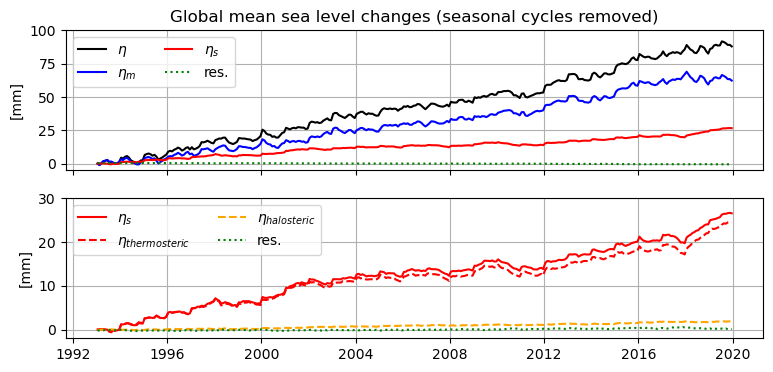

In [48]:

res_area = eta_dess_area - etam_dess_area - etas_dess_area 
res_areaSteric = etas_dess_area - etas_T_dess_area - etas_S_dess_area 
fac = 1e3

plt.figure(figsize=(9,4))
plt.subplot(2,1,1)
# ax = fig.add_subplot(2, 2, 1)
plt.plot(eta_dess_area['time'], eta_dess_area*fac - eta_dess_area[0]*fac, label='$\eta$', color='k')
plt.plot(etam_dess_area['time'], etam_dess_area*fac - etam_dess_area[0]*fac, label='$\eta_m$', color='b')
plt.plot(etas_dess_area['time'], etas_dess_area*fac - etas_dess_area[0]*fac, label='$\eta_s$', color='r')
plt.plot(res_area['time'], res_area*fac, label='res.', color='g', linestyle=':')

plt.ylim(-5, 100)
plt.ylabel('[mm]')
plt.legend(ncol=2)
plt.grid(True) 
plt.title('Global mean sea level changes (seasonal cycles removed)')
plt.xlabel('') 
ax = plt.gca()
ax.set_xticklabels([])

plt.subplot(2,1,2)
plt.plot(etas_dess_area['time'], etas_dess_area*fac - etas_dess_area[0]*fac, label='$\eta_s$', color='r')
plt.plot(etas_T_dess_area['time'], etas_T_dess_area*fac - etas_T_dess_area[0]*fac, label='$\eta_{thermosteric}$', color='r', linestyle='--')
plt.plot(etas_S_dess_area['time'], etas_S_dess_area*fac - etas_S_dess_area[0]*fac, label='$\eta_{halosteric}$', color='orange', linestyle='--')
plt.plot(res_areaSteric['time'], res_areaSteric*fac, label='res.', color='g', linestyle=':')
plt.ylim(-2, 30)
plt.ylabel('[mm]')
plt.legend(ncol=2)
plt.grid(True) 

# plt.savefig("/home/jovyan/ESS25-Team_PISEAL/figures/GMSL_dess.png", dpi=600, bbox_inches='tight')

## plot linear trends

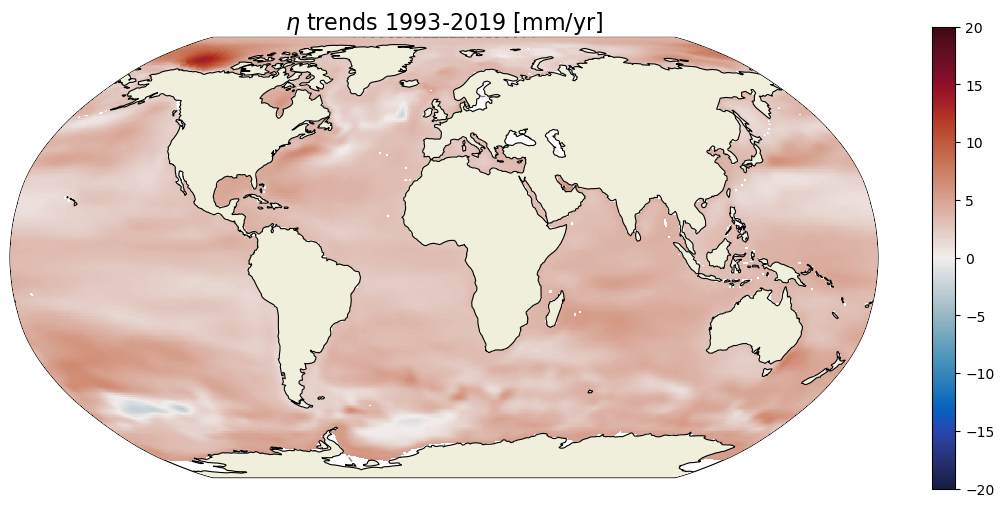

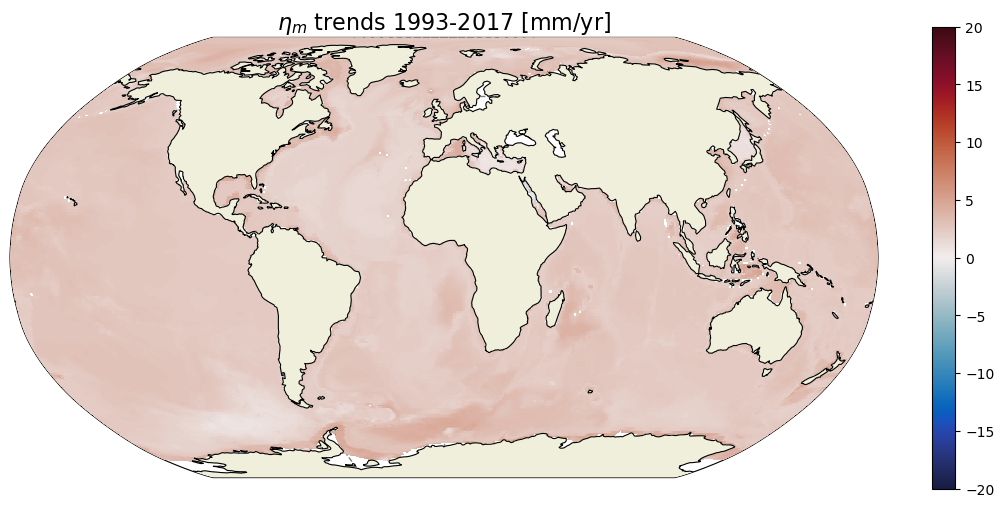

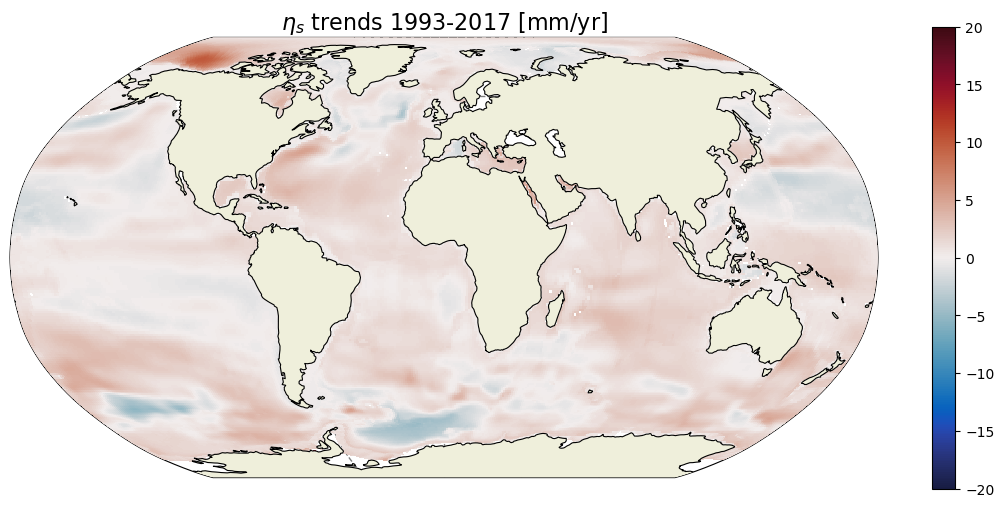

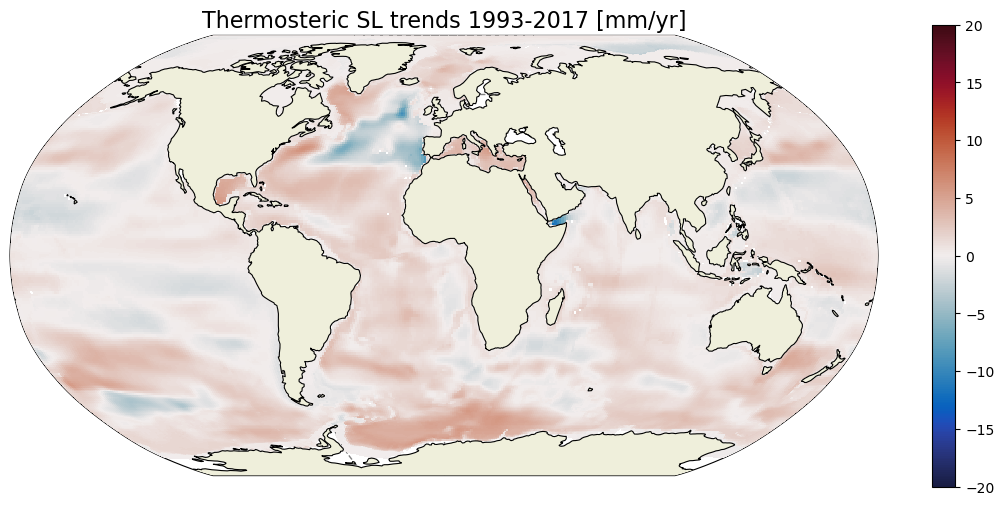

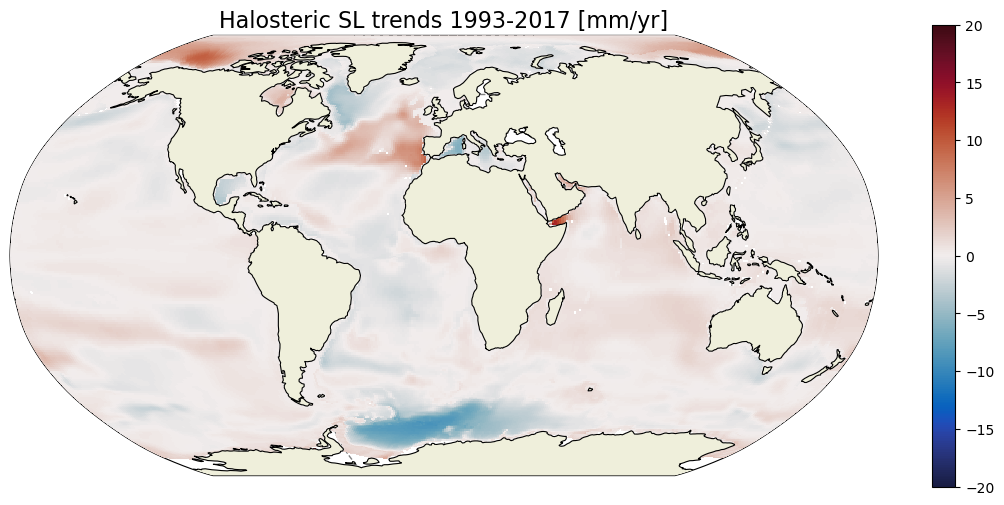

In [27]:
fig = plt.figure(figsize=[14,6])
# ax = fig.add_subplot(2, 2, 1)

ecco.plot_proj_to_latlon_grid(ds_grid.XC,ds_grid.YC,trend_eta, 
                              show_colorbar=True,
                              show_grid_lines=True,
                              cmin=-20, cmax=20, 
                              cmap=cmocean.cm.balance);
plt.title('$\eta$ trends 1993-2019 [mm/yr]',fontsize=16)
# plt.savefig("/home/jovyan/ESS25-Team_PISEAL/figures/trends_eta.png", dpi=600, bbox_inches='tight')


plt.figure(figsize=[14,6]);
ecco.plot_proj_to_latlon_grid(ds_grid.XC,ds_grid.YC,trend_etam, 
                              show_colorbar=True,
                              show_grid_lines=True,
                              cmin=-20, cmax=20, 
                              cmap=cmocean.cm.balance);
plt.title('$\eta_m$ trends 1993-2017 [mm/yr]',fontsize=16)
# plt.savefig("/home/jovyan/ESS25-Team_PISEAL/figures/trends_etas.png", dpi=600, bbox_inches='tight')

plt.figure(figsize=[14,6]);
ecco.plot_proj_to_latlon_grid(ds_grid.XC,ds_grid.YC,trend_etas, 
                              show_colorbar=True,
                              show_grid_lines=True,
                              cmin=-20, cmax=20, 
                              cmap=cmocean.cm.balance);
plt.title('$\eta_s$ trends 1993-2017 [mm/yr]',fontsize=16)
# plt.savefig("/home/jovyan/ESS25-Team_PISEAL/figures/trends_etam.png", dpi=600, bbox_inches='tight')


plt.figure(figsize=[14,6]);
ecco.plot_proj_to_latlon_grid(ds_grid.XC,ds_grid.YC,trend_etas_T, 
                              show_colorbar=True,
                              show_grid_lines=True,
                              cmin=-20, cmax=20, 
                              cmap=cmocean.cm.balance);
plt.title('Thermosteric SL trends 1993-2017 [mm/yr]',fontsize=16)
# plt.savefig("/home/jovyan/ESS25-Team_PISEAL/figures/trends_etas_T.png", dpi=600, bbox_inches='tight')

plt.figure(figsize=[14,6]);
ecco.plot_proj_to_latlon_grid(ds_grid.XC,ds_grid.YC,trend_etas_S, 
                              show_colorbar=True,
                              show_grid_lines=True,
                              cmin=-20, cmax=20, 
                              cmap=cmocean.cm.balance);
plt.title('Halosteric SL trends 1993-2017 [mm/yr]',fontsize=16)
# plt.savefig("/home/jovyan/ESS25-Team_PISEAL/figures/trends_etas_S.png", dpi=600, bbox_inches='tight')

## plot variance explained

In [16]:
# 
# eta_dess_area = eta_dess.weighted(ds_grid.rA).mean(dim=('tile', "j", "i")) 
# etam_dess_area = etam_dess.weighted(ds_grid.rA).mean(dim=('tile', "j", "i"))
# etas_dess_area = etas_dess.weighted(ds_grid.rA).mean(dim=('tile', "j", "i"))
# etas_T_dess_area = etasT_dess.weighted(ds_grid.rA).mean(dim=('tile', "j", "i"))
# etas_S_dess_area = etasS_dess.weighted(ds_grid.rA).mean(dim=('tile', "j", "i"))

# varexp_m = 1 - (eta_dess - etam_dess).var(dim="time") / eta_dess.var(dim="time")
# varexp_s = 1 - (eta_dess - etas_dess).var(dim="time") / eta_dess.var(dim="time")
# # 
# varexp_th = 1 - (etas_dess - etasT_dess).var(dim="time") / etas_dess.var(dim="time")
# varexp_ha = 1 - (etas_dess - etasS_dess).var(dim="time") / etas_dess.var(dim="time")


varexp_m = 1 - (eta_anom - etam_anom).var(dim="time") / eta_anom.var(dim="time")
varexp_s = 1 - (eta_anom - etas_anom).var(dim="time") / eta_anom.var(dim="time")
# 
varexp_th = 1 - (etas_anom - etas_T_anom).var(dim="time") / etas_anom.var(dim="time")
varexp_ha = 1 - (etas_anom - etas_S_anom).var(dim="time") / etas_anom.var(dim="time")

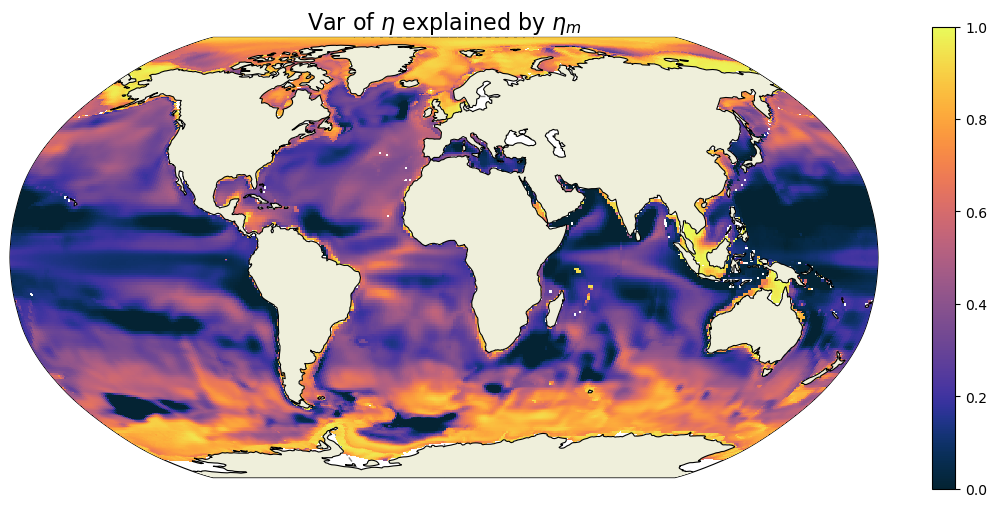

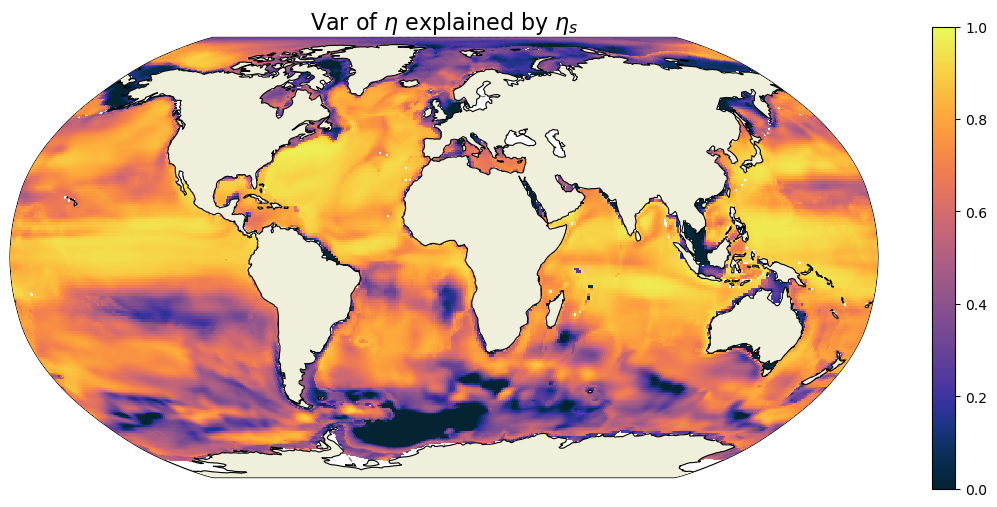

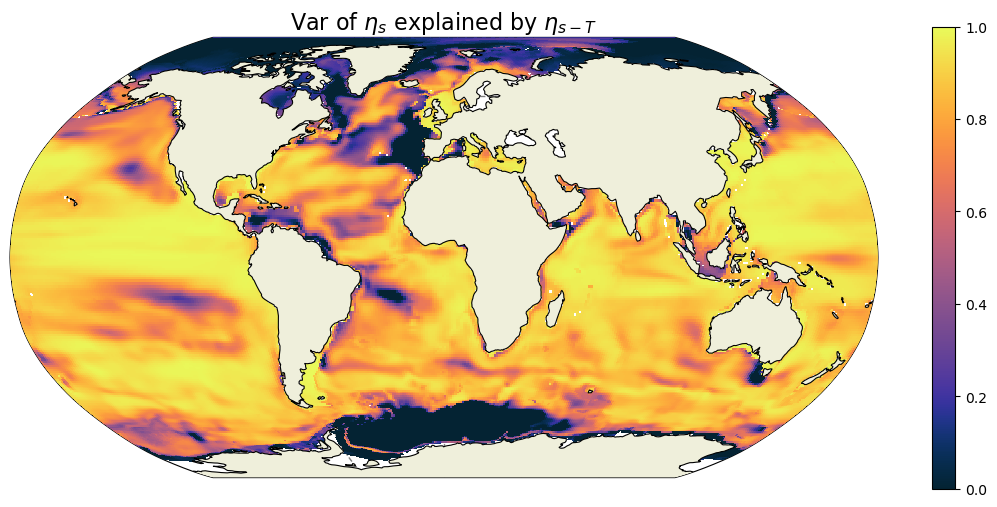

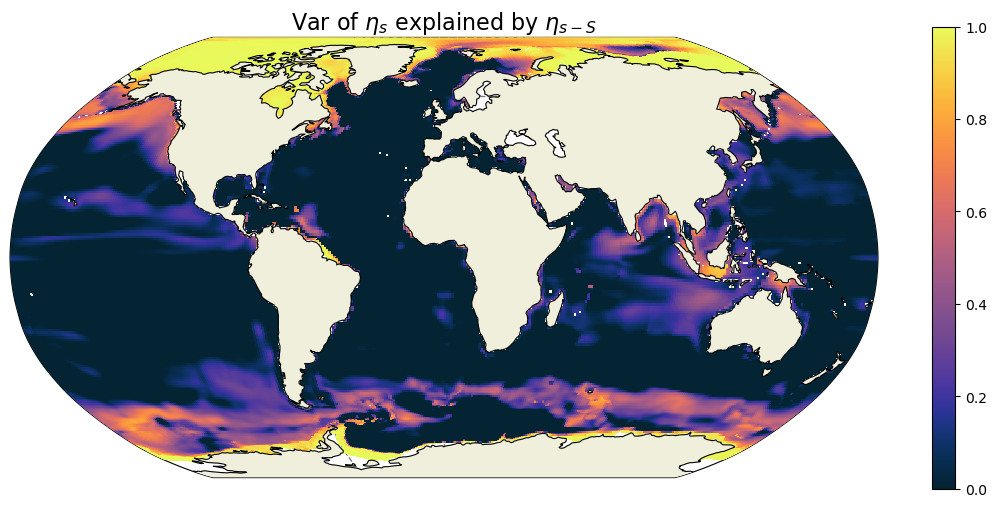

In [18]:
plt.figure(figsize=[14,6])
ecco.plot_proj_to_latlon_grid(ds_grid.XC,ds_grid.YC,varexp_m, 
                              show_colorbar=True,
                              show_grid_lines=True,
                              cmin=0, cmax=1, 
                              cmap=cmocean.cm.thermal)
plt.title('Var of $\eta$ explained by $\eta_m$',fontsize=16)
plt.savefig("/home/jovyan/ESS25-Team_PISEAL/figures/varexp_m_ss.png", dpi=600, bbox_inches='tight')


plt.figure(figsize=[14,6])
ecco.plot_proj_to_latlon_grid(ds_grid.XC,ds_grid.YC,varexp_s, 
                              show_colorbar=True,
                              show_grid_lines=True,
                              cmin=0, cmax=1, 
                              cmap=cmocean.cm.thermal)
plt.title('Var of $\eta$ explained by $\eta_s$',fontsize=16)
plt.savefig("/home/jovyan/ESS25-Team_PISEAL/figures/varexp_s_ss.png", dpi=600, bbox_inches='tight')


plt.figure(figsize=[14,6])
ecco.plot_proj_to_latlon_grid(ds_grid.XC,ds_grid.YC,varexp_th, 
                              show_colorbar=True,
                              show_grid_lines=True,
                              cmin=0, cmax=1, 
                              cmap=cmocean.cm.thermal)
plt.title('Var of $\eta_s$ explained by $\eta_{s-T}$',fontsize=16)
plt.savefig("/home/jovyan/ESS25-Team_PISEAL/figures/varexp_sbyT_ss.png", dpi=600, bbox_inches='tight')


plt.figure(figsize=[14,6])
ecco.plot_proj_to_latlon_grid(ds_grid.XC,ds_grid.YC,varexp_ha, 
                              show_colorbar=True,
                              show_grid_lines=True,
                              cmin=0, cmax=1, 
                              cmap=cmocean.cm.thermal)
plt.title('Var of $\eta_s$ explained by $\eta_{s-S}$',fontsize=16)
plt.savefig("/home/jovyan/ESS25-Team_PISEAL/figures/varexp_sbyS_ss.png", dpi=600, bbox_inches='tight')


## plot residual of $\eta$

In [ ]:
eta_tm = eta_anom.mean(dim='time')
etam_tm = etam_anom.mean(dim='time')
etas_tm = etas_anom.mean(dim='time')
res_tm = eta_tm - etam_tm - etas_tm

# -- errors
# relerr = (eta_anom - etam_anom - etas_anom) / eta_anom
std_re = (eta_anom - etam_anom - etas_anom).std(dim='time') / eta_anom.std(dim='time')

std_eta = eta_anom.std(dim='time')

corr_eta = xr.corr(eta_anom, etam_anom+etas_anom, dim="time")

rat = abs(res_tm/eta_tm)

plt.figure(figsize=[14,6])
ecco.plot_proj_to_latlon_grid(ds_grid.XC,ds_grid.YC,eta_tm, 
                              show_colorbar=True,
                              show_grid_lines=True,
                              cmin=-.5, cmax=.5, 
                              cmap=cmocean.cm.balance)
plt.title('mean $\eta$ 1993-2019',fontsize=16)
# plt.savefig("/home/jovyan/ESS25-Team_PISEAL/figures/varexp_s_ss.png", dpi=600, bbox_inches='tight')


plt.figure(figsize=[14,6])
ecco.plot_proj_to_latlon_grid(ds_grid.XC,ds_grid.YC,etam_tm+etas_tm, 
                              show_colorbar=True,
                              show_grid_lines=True,
                              cmin=-.5, cmax=.5, 
                              cmap=cmocean.cm.balance)
plt.title('$\eta_m + \eta_s$',fontsize=16)


plt.figure(figsize=[14,6])
ecco.plot_proj_to_latlon_grid(ds_grid.XC,ds_grid.YC,res_tm, 
                              show_colorbar=True,
                              show_grid_lines=True,
                              cmin=-2e-2, cmax=2e-2, 
                              cmap=cmocean.cm.balance)
plt.title('res',fontsize=16)

plt.figure(figsize=[14,6])
ecco.plot_proj_to_latlon_grid(ds_grid.XC,ds_grid.YC,std_eta, 
                              show_colorbar=True,
                              show_grid_lines=True,
                              cmin=0, cmax=.2, 
                              cmap=cmocean.cm.amp)
plt.title('std(eta)',fontsize=16)

plt.figure(figsize=[14,6])
ecco.plot_proj_to_latlon_grid(ds_grid.XC,ds_grid.YC,std_re, 
                              show_colorbar=True,
                              show_grid_lines=True,
                              cmin=0, cmax=.4, 
                              cmap=cmocean.cm.amp)
plt.title('std(res)/std($\eta$)',fontsize=16)

plt.figure(figsize=[14,6])
ecco.plot_proj_to_latlon_grid(ds_grid.XC,ds_grid.YC,corr_eta, 
                              show_colorbar=True,
                              show_grid_lines=True,
                              cmin=-1, cmax=1, 
                              cmap=cmocean.cm.balance)
plt.title('corr($\eta$,$\eta_m + \eta_s$)',fontsize=16)

<xarray.DataArray 'time' ()> Size: 8B
array('1993-12-16T12:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 8B 1993-12-16T12:00:00
Attributes:
    axis:                   T
    bounds:                 time_bnds
    comment:                 
    coverage_content_type:  coordinate
    long_name:              center time of averaging period
    standard_name:          time

<Figure size 1400x600 with 0 Axes>

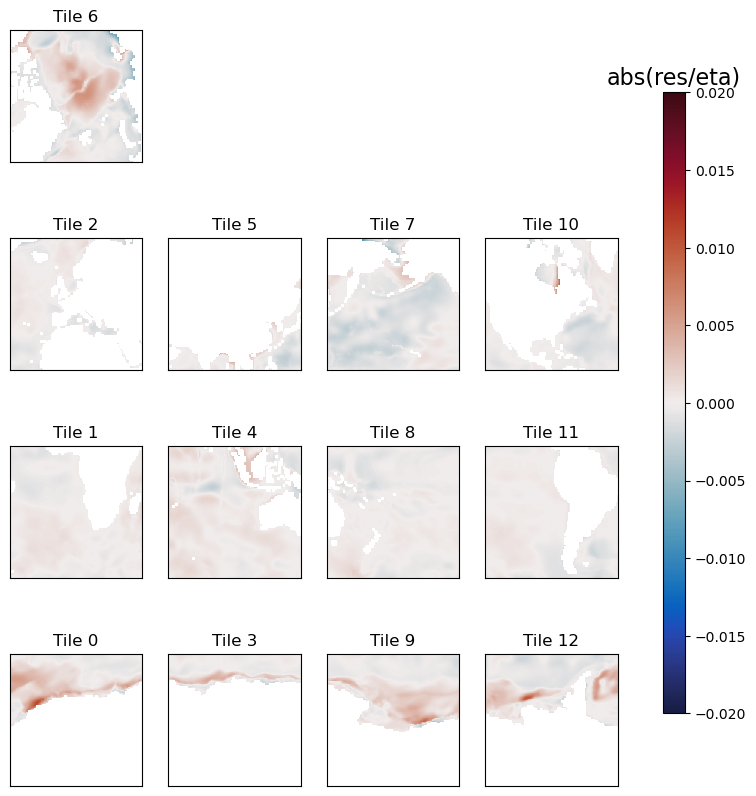

In [19]:
res = eta_anom - etam_anom - etas_anom
it = 11

plt.figure(figsize=[14,6])
ecco.plot_tiles(res[it,:,:,:], show_colorbar=True,  #res[0,:,:,:]
                cmin=-.02, cmax=.02, 
                cmap=cmocean.cm.balance, 
                rotate_to_latlon=True, layout='latlon',
                show_tile_labels=True);
plt.title('abs(res/eta)',fontsize=16)
res.time[it]

In [ ]:
# help(ecco.plot_proj_to_latlon_grid)
fmean = res.weighted(ds_grid.rA).mean(dim=("j", "i")) 
fmean_s = etas_anom.weighted(ds_grid.rA).mean(dim=("j", "i")) 
fmean_re = (etas_anom+etam_anom).weighted(ds_grid.rA).mean(dim=("j", "i")) 
fmean_eta = eta_anom.weighted(ds_grid.rA).mean(dim=("j", "i")) 

fmean

plt.figure(figsize=(9,4))
plt.plot(fmean['time'], fmean[:,0], label='res', color='k')
plt.plot(fmean_s['time'], fmean_s[:,0], label='$\eta_s$', color='r')

plt.figure(figsize=(9,4))
plt.plot(fmean_eta['time'], fmean_eta[:,0], label='res', color='k')
plt.plot(fmean_re['time'], fmean_re[:,0], label='$\eta_s$', color='r')

In [67]:
ds_PRE

<xarray.Dataset> Size: 713MB
Dimensions:    (time: 336, tile: 13, j: 90, i: 90, nb: 4, j_g: 90, i_g: 90,
                nv: 2)
Coordinates: (12/13)
  * time       (time) datetime64[ns] 3kB 1992-01-16T18:00:00 ... 2019-12-16
    XC         (tile, j, i) float32 421kB dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    XC_bnds    (tile, j, i, nb) float32 2MB dask.array<chunksize=(13, 90, 90, 4), meta=np.ndarray>
    XG         (tile, j_g, i_g) float32 421kB dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    YC         (tile, j, i) float32 421kB dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    YC_bnds    (tile, j, i, nb) float32 2MB dask.array<chunksize=(13, 90, 90, 4), meta=np.ndarray>
    ...         ...
  * i          (i) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * i_g        (i_g) int32 360B 0 1 2 3 4 5 6 7 8 ... 81 82 83 84 85 86 87 88 89
  * j          (j) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * j_g        (j_g) int32 360B 0 1 2 3 4 5 6 7 8 ... 81 82 83 84 85 86 87 88 89
  * tile       (tile) int32 52B 0 1 2 3 4 5 6 7 8 9 10 11 12
    time_bnds  (time, nv) datetime64[ns] 5kB dask.array<chunksize=(2, 2), meta=np.ndarray>
Dimensions without coordinates: nb, nv
Data variables:
    OBP        (time, tile, j, i) float32 142MB dask.array<chunksize=(2, 13, 90, 90), meta=np.ndarray>
    OBPAnoma   (time, tile, j, i) float32 142MB dask.array<chunksize=(2, 13, 90, 90), meta=np.ndarray>
    OBPGMAP    (time, tile, j, i) float32 142MB dask.array<chunksize=(2, 13, 90, 90), meta=np.ndarray>
    OBPGMAPA   (time, tile, j, i) float32 142MB dask.array<chunksize=(2, 13, 90, 90), meta=np.ndarray>
    PHIBOT     (time, tile, j, i) float32 142MB dask.array<chunksize=(2, 13, 90, 90), meta=np.ndarray>
Attributes: (12/59)
    Conventions:                  CF-1.8, ACDD-1.3
    acknowledgement:              This research was carried out by the Jet Pr...
    author:                       Ian Fenty, Ou Wang, Ichiro Fukumori
    cdm_data_type:                Grid
    comment:                      Fields provided on the curvilinear lat-lon-...
    coordinates_comment:          Note: the global 'coordinates' attribute de...
    ...                           ...
    time_coverage_duration:       P1M
    time_coverage_end:            1992-02-01T00:00:00
    time_coverage_resolution:     P1M
    time_coverage_start:          1992-01-01T12:00:00
    title:                        ECCO Ocean Bottom Pressure - Monthly Mean l...
    uuid:                         7bc60038-2c35-11f0-b9c7-0a58a9feac02